In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from einops.layers.torch import Rearrange
from einops import rearrange

from typing import Any, Dict, Tuple, Optional
from game_mechanics import (
    ChooseMoveCheckpoint,
    ShooterEnv,
    checkpoint_model,
    choose_move_randomly,
    human_player,
    load_network,
    play_shooter,
    save_network,
)
from tqdm.notebook import tqdm

from functools import partial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import partial

from utils import *
%load_ext autoreload
%autoreload 2

pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Error in the GAE calculation

Verdict: Tim has a slight error, non-consequential

In [69]:
def gae(rewards, values, successor_values, dones, gamma, lamda):
    N = len(rewards)
    deltas = rewards + gamma * successor_values - values
    print(deltas)
    gamlam = gamma * lamda
    gamlam_geo_series = torch.as_tensor([gamlam**i for i in range(N)])*(1-gamlam)
    full_gamlam_matrix = torch.stack([torch.roll(gamlam_geo_series, shifts=n) for n in range(N)])
    full_gamlam_matrix = torch.triu(full_gamlam_matrix)

    done_indexes = torch.squeeze(dones.nonzero(), dim=1).tolist()
    for terminal_index in done_indexes:
        full_gamlam_matrix[: terminal_index + 1, terminal_index + 1:] = 0

    end_index = torch.arange(N)
    for start, end in zip([-1]+done_indexes[:-1], done_indexes):
        end_index[start+1:end+1] = end
    # make sure it sums to one:
    # (by making the term for the last value be 1 - sum(all other terms))
    full_gamlam_matrix[torch.arange(N), end_index] += 1 - full_gamlam_matrix.sum(axis=1)
    plt.imshow(full_gamlam_matrix)
    return full_gamlam_matrix @ deltas

# Tom's version:
def calculate_gae(
        rewards: torch.Tensor,
        values: torch.Tensor,
        successor_values: torch.Tensor,
        is_terminals: torch.Tensor,
        gamma: float,
        lamda: float,
):
    """
    Calculate the Generalized Advantage Estimator (GAE) for a batch of transitions.

    GAE = \sum_{t=0}^{T-1} (gamma * lamda)^t * (r_{t+1} + gamma * V_{t+1} - V_t)
    """
    N = len(rewards)

    # Gets the delta terms: the TD-errors
    delta_terms = rewards + gamma * successor_values - values
    gamlam = gamma * lamda
    gamlam_geo_series = torch.tensor([gamlam ** n for n in range(N)])
    # Shift the coefficients to the right for each successive row
    full_gamlam_matrix = torch.stack([torch.roll(gamlam_geo_series, shifts=n) for n in range(N)])
    # Sets everything except upper-triangular to 0
    gamlam_matrix = torch.triu(full_gamlam_matrix)
    # Zero out terms that are after an episode termination
    for terminal_index in torch.squeeze(is_terminals.nonzero(), dim=1):
        gamlam_matrix[: terminal_index + 1, terminal_index + 1:] = 0
    return torch.matmul(gamlam_matrix, delta_terms)



In [72]:
rewards = torch.ones(20)
values = torch.ones(20)*10
successor_values = torch.ones(20)*10
gamma = 0.93
lamda = 0.8
is_terminals = torch.zeros(20)
is_terminals[[9, 19]] = 1

tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000])


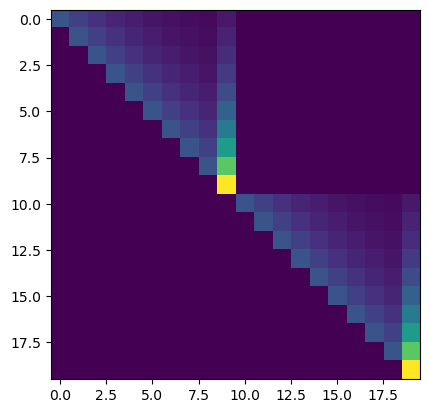

In [73]:
a = gae(rewards, values, successor_values, is_terminals, gamma, lamda)
b = calculate_gae(rewards, values, successor_values, is_terminals, gamma, lamda)

In [67]:
a

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000])

In [68]:
b

tensor([1.9494, 1.9071, 1.8515, 1.7782, 1.6819, 1.5551, 1.3883, 1.1688, 0.8800,
        0.5000, 1.9494, 1.9071, 1.8515, 1.7782, 1.6819, 1.5551, 1.3883, 1.1688,
        0.8800, 0.5000])